# Detection of Malaria from Cell Images

### What is Malaria?

Malaria is a potentially life-threatening parasitic disease caused by infection with Plasmodium protozoa transmitted by an infective female Anopheles mosquito. Plasmodium falciparum infection carries a poor prognosis with a high mortality if untreated, but it has an excellent prognosis if diagnosed early and treated appropriately.

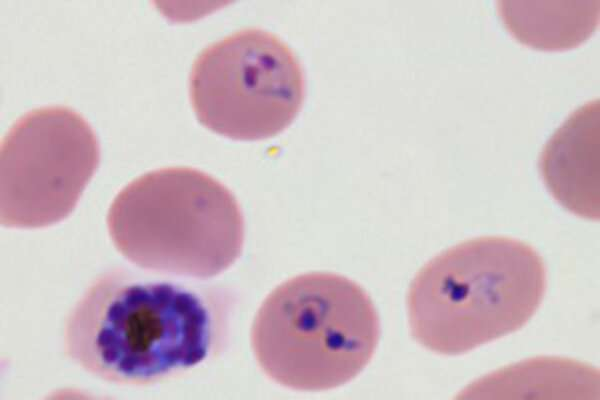

In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import metrics
from keras import Model, layers
from keras.callbacks import *
from keras.models import load_model, model_from_json

Dataset can be downloaded from here: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [2]:
parasitized_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
uninfected_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/')

Images of malaria infected cells


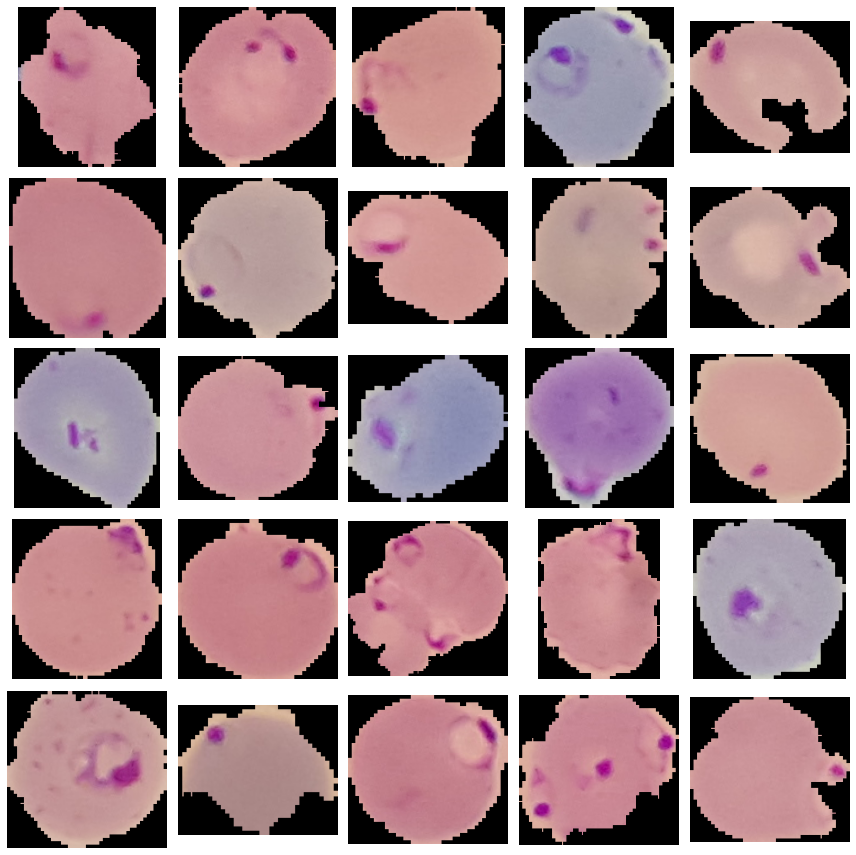

In [3]:
def plotImages(title,directory):
    print(title)
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread( directory+ "/" + parasitized_data[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.tight_layout()
    plt.show()
        
plotImages("Images of malaria infected cells","../input/cell-images-for-detecting-malaria/cell_images/Parasitized") 

Images of Uninfected cells


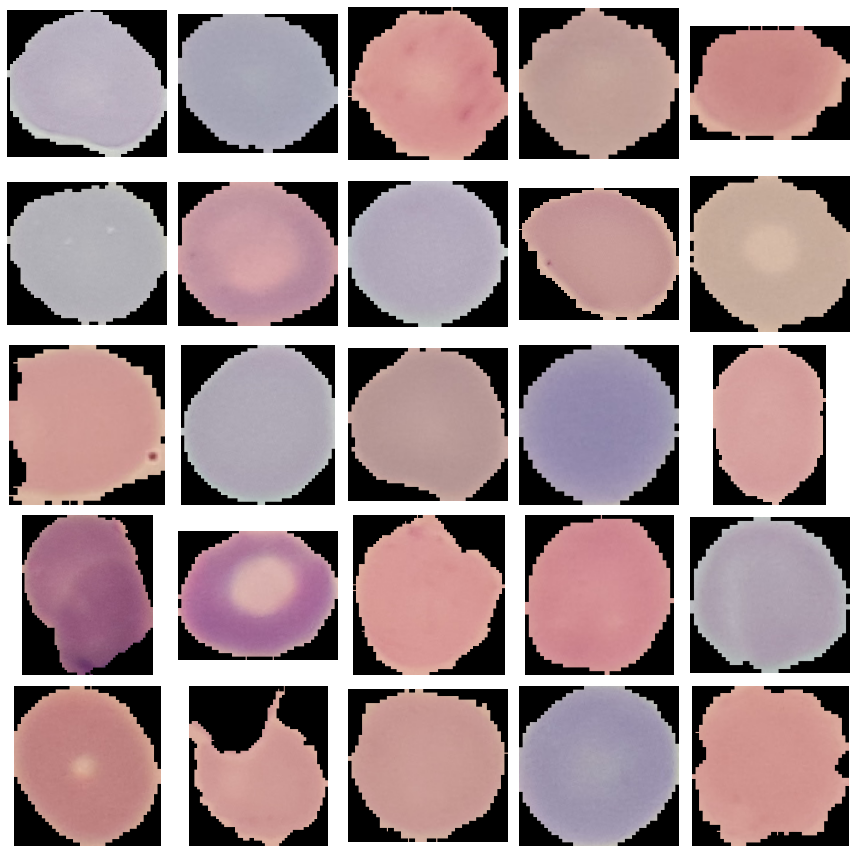

In [5]:
def plotImages(title,directory):
    print(title)
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cv2.imread( directory+ "/" + uninfected_data[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.tight_layout()
    plt.show()
        
plotImages("Images of Uninfected cells","../input/cell-images-for-detecting-malaria/cell_images/Uninfected") 

We can clearly observe from images above the difference between the infected and uninfected cells. We can see a small pink colored clot inside the cellular image for infected while for the uninfected the cellular image is clean without any clots.

In [5]:
workingDir = "/kaggle/input/cell-images-for-detecting-malaria"

PATH = os.path.sep.join([workingDir, "cell_images"])

# Getting the path ot the training directory 
train_dir = os.path.join(PATH, "cell_images")

# Getting the path to the validation directory 
validation_dir = os.path.join(PATH, "cell_images")

In [6]:
# Getting the path to the directory for the parasitized training cell images and 
# the getting the path to the directory for the uninfected training cell images 
parasitized_train_dir = os.path.join(train_dir, "Parasitized")
uninfected_train_dir = os.path.join(train_dir, "Uninfected")

# Getting the path to the directory for the parasitized validation cell images and 
# the path to the directory for the uninfected validation cell images 
parasitized_val_dir = os.path.join(validation_dir, "Parasitized") 
uninfected_val_dir = os.path.join(validation_dir, "Uninfected")

In [7]:
# Getting the number of images present in the parasitized training directory and the 
# number of images present in the uninfected training directory 
parasitized_images = len(os.listdir(parasitized_train_dir))
uninfected_images = len(os.listdir(uninfected_train_dir))

# Getting the number of images present in the parasitized validation directory and the 
# number of images present in the uninfected validation directory 
parasitized_images_val = len(os.listdir(parasitized_val_dir)) 
uninfected_images_val = len(os.listdir(uninfected_val_dir)) 

# Getting the sum of both the training images and validation images 
total_train = parasitized_images + uninfected_images  
total_val = parasitized_images_val + uninfected_images_val 

# Displaying the results for Training images  
print("Total Training parasitized images: {}".format(parasitized_images)); 
print("Total Training uninfected images: {}".format(uninfected_images)); 
print("__________________________________________________________________________________________________________\n");

# Displaying the results for Validation images  
print("Total Validation parasitized images: {}".format(parasitized_images_val)); 
print("Total Validation uninfected images: {}".format(uninfected_images_val)); 
print("__________________________________________________________________________________________________________\n"); 

# Displaying the total values for the images in both the training and validation directory 
print("Total Train: {}".format(total_train)); 
print("Total Validation: {}".format(total_val)); 

Total Training parasitized images: 13780
Total Training uninfected images: 13780
__________________________________________________________________________________________________________

Total Validation parasitized images: 13780
Total Validation uninfected images: 13780
__________________________________________________________________________________________________________

Total Train: 27560
Total Validation: 27560


In [9]:
batch_size = 2000
epochs = 20 
IMG_HEIGHT = 98 
IMG_WIDTH = 98 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(directory = validation_dir,
                                                  target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True
                                                 )

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


In [10]:
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=[IMG_HEIGHT, IMG_WIDTH] + [3],
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = Flatten()(vgg19.output)
prediction = Dense(1, activation='sigmoid')(x)

80142336/80134624 [==============================] - 0s 0us/step


In [11]:
# create a model object
model = Model(inputs = vgg19.input, outputs = prediction)

# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 98, 98, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 98, 98, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 98, 98, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 49, 49, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 49, 49, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 49, 49, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)      

In [15]:
# tell the model what cost and optimization method to use

metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
          ]

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics
)

In [16]:
# Training the model on the input data by using the fit_generator function 
history = model.fit_generator(train_generator, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_generator, 
                       validation_steps = total_val // batch_size) 

Epoch 1/20
13/13 [==============================] - 273s 21s/step - loss: 0.6659 - accuracy: 0.5959 - precision: 0.5928 - recall: 0.6129 - val_loss: 0.5532 - val_accuracy: 0.7664 - val_precision: 0.8306 - val_recall: 0.6694
Epoch 2/20
13/13 [==============================] - 205s 16s/step - loss: 0.5282 - accuracy: 0.7592 - precision: 0.7697 - recall: 0.7399 - val_loss: 0.4654 - val_accuracy: 0.7928 - val_precision: 0.7724 - val_recall: 0.8312
Epoch 3/20
13/13 [==============================] - 208s 16s/step - loss: 0.4557 - accuracy: 0.8087 - precision: 0.8073 - recall: 0.8112 - val_loss: 0.4259 - val_accuracy: 0.8101 - val_precision: 0.7613 - val_recall: 0.9046
Epoch 4/20
13/13 [==============================] - 212s 16s/step - loss: 0.4115 - accuracy: 0.8392 - precision: 0.8269 - recall: 0.8572 - val_loss: 0.4035 - val_accuracy: 0.8179 - val_precision: 0.7557 - val_recall: 0.9390
Epoch 5/20
13/13 [==============================] - 207s 16s/step - loss: 0.3816 - accuracy: 0.8532 - pr

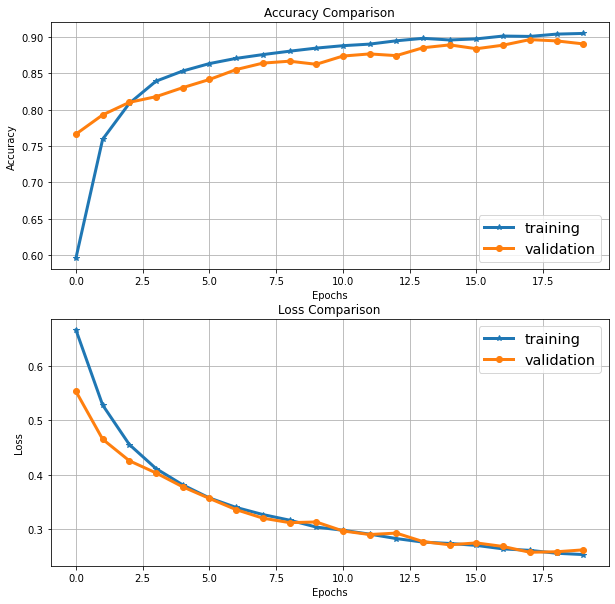

In [17]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(history)


In [19]:
model_test_performace = model.evaluate(validation_generator)


14/14 [==============================] - 50s 4s/step - loss: 0.2617 - accuracy: 0.8911 - precision: 0.8378 - recall: 0.9702


In [23]:
# Saving the model for further uses 
modelName = "MalariaModel.h5" 
model.save_weights(modelName); 

In [35]:
img = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized"

# Getting the first Four images 
ImgDir = list(os.listdir(img)) 
ImgDir = ImgDir[:3] 

# Loading Just a random image from the Parasitized images folder. 
imagePath = os.path.join(img, "C99P60ThinF_IMG_20150918_141001_cell_133.png")

# Displaying the full path to the parasitized image we want to use for prediction. 
print(imagePath)

/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_133.png


Loaded Image Shape: (145, 142, 3)


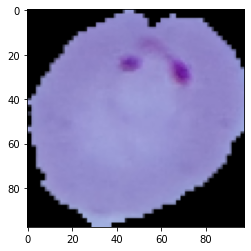

The Predicted Class is: Parasitized


In [36]:
img = cv2.imread(imagePath); 

# Setting the dimensions for the loaded image to be converted into and displaying the shape of the image 
print("Loaded Image Shape: {}".format(img.shape)); 
dim = (IMG_HEIGHT, IMG_WIDTH); 

# Resizing the image 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA); 
plt.grid(False) 
plt.imshow(img) 
plt.show() 

# Expanding the image dimensions 
image = np.expand_dims(img, axis = 0); 

# Making Final Predictions 
result = model.predict(image)
# Creating a loop to get the actual predicted class 
for key, value in (train_generator.class_indices.items()): 
    if value == result: 
        print("The Predicted Class is: {}".format(key))